![](https://camo.githubusercontent.com/4ed246eb4c5a73d3c02c1b094c1274219d40f68a9cfb6010e6f4552769e4689b/68747470733a2f2f68706174636865732e6769746875622e696f2f6173736574732f68706174636865732d6c6f676f2e706e67)
# Executing BEBLID in Hpatches


The following Python Notebook shows how to evaluate a local descriptor in [HPatches dataset](https://hpatches.github.io). We prove it for [BEBLID](https://docs.opencv.org/4.x/d7/d99/classcv_1_1xfeatures2d_1_1BEBLID.html), but the same can be done for [TEBLID](https://docs.opencv.org/4.x/dd/dc1/classcv_1_1xfeatures2d_1_1TEBLID.html) (which is a improved version of BEBLID), [HashSIFT](https://github.com/iago-suarez/efficient-descriptors), [SOSNet](https://github.com/scape-research/SOSNet) or any other.

![](https://github.com/hpatches/hpatches-dataset/blob/master/img/images.png?raw=true)

In [ ]:
# Download the benchmark repository
!git clone https://github.com/iago-suarez/hpatches-benchmark.git -b no-libupm hpatches

Cloning into 'hpatches'...
remote: Enumerating objects: 1672, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1672 (delta 132), reused 155 (delta 128), pack-reused 1512
Receiving objects: 100% (1672/1672), 296.72 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (986/986), done.
Checking out files: 100% (232/232), done.


In [ ]:
# Donwload the benchmark content
!cd hpatches && sh download.sh hpatches && cd ..


>> Please wait, downloading the HPatches patches dataset ~4.2G

--2022-12-13 21:10:01--  http://icvl.ee.ic.ac.uk/vbalnt/hpatches/hpatches-release.tar.gz
Resolving icvl.ee.ic.ac.uk (icvl.ee.ic.ac.uk)... 155.198.116.158
Connecting to icvl.ee.ic.ac.uk (icvl.ee.ic.ac.uk)|155.198.116.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4467627904 (4.2G) [application/x-gzip]
Saving to: ‘./data/hpatches-release.tar.gz’

./data/hpatches-rel 100%[===================>]   4.16G  30.3MB/s    in 2m 22s  

2022-12-13 21:12:23 (30.0 MB/s) - ‘./data/hpatches-release.tar.gz’ saved [4467627904/4467627904]

>> Please wait, extracting the HPatches patches dataset ~4.2G
>> Done!


In [ ]:
# Install some necessary requirements
!sudo apt install cm-super dvipng texlive-latex-extra texlive-fonts-recommended 
!pip install numpy matplotlib opencv-contrib-python>=4.5 joblib pandas dill tqdm scipy tabulate future 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [ ]:
#@title PatchClustersDataset class definition
# Create a generic dataset class
import glob
import json
import logging
import os.path
import pickle
from collections import namedtuple

import cv2
import numpy as np
from tqdm import tqdm

Size = namedtuple('Size', ('width', 'height'))


def touch_dir(dir_name):
    """
    Creates a directory if it doesn't exists
    :param dir_name: The directory to be created.
    :type dir_name: str
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


class PatchClustersDataset:
    """Represents a dataset of clusters, where each sample is a image patch.
    The associated labels determine each cluster and represents the same 3D region."""

    @property
    def dataset_name(self):
        return self.__dataset_name

    @property
    def n_samples(self):
        return self._n_samples

    @property
    def patch_size(self):
        return self.__patch_size

    @property
    def original_patch_size(self):
        return self.__original_patch_size

    @property
    def preprocessor(self):
        return self.__preprocessor

    @property
    def is_data_preprocessed(self):
        return self._is_data_preprocessed

    @property
    def data(self):
        return self._data

    @property
    def cluster_labels(self):
        return self._cluster_labels

    @property
    def imgs_names(self):
        return self._imgs_names

    @property
    def full_name(self):
        return "{} ({},{}) {}".format(
            self.dataset_name,
            str(self.patch_size.width),
            str(self.patch_size.height),
            "None" if self.preprocessor is None else self.preprocessor.get_preprocessor_name())

    @property
    def data_augmentation(self):
        return self._data_augmentation

    @property
    def extra_info(self):
        return self._extra_info

    @property
    def patch_margin(self):
        return self._patch_margin

    def __init__(self, dataset_name, preprocessor=None, patch_size=Size(32, 32), original_patch_size=Size(64, 64),
                 data_augmentation=False, patch_margin=0):
        self.__dataset_name = dataset_name
        self.__preprocessor = preprocessor
        self.__patch_size = patch_size
        self.__original_patch_size = original_patch_size
        self._data_augmentation = data_augmentation
        self._n_samples = None
        self._is_data_preprocessed = None
        self._data = None
        self._cluster_labels = None
        self._imgs_names = None
        self._extra_info = None
        self._patch_margin = patch_margin

    @dataset_name.setter
    def dataset_name(self, dataset_name):
        self.__dataset_name = dataset_name

    @preprocessor.setter
    def preprocessor(self, preprocessor):
        self.__preprocessor = preprocessor


In [ ]:
#@title HpatchesPatchClustersDataset class definition

# For the remaining 5 images in the sequence, we provide three patch sets
# `eK.png` and `hK.png` and `tK.png`, containing the corresponding patches from
# `ref.png` as found in the `K-th` image with increasing amounts of geometric noise (`e`<`h`<`t`).
TPS = {
    'all': ['ref', 'e1', 'e2', 'e3', 'e4', 'e5', 'h1', 'h2', 'h3', 'h4', 'h5', 't1', 't2', 't3', 't4', 't5'],
    'easy': ['ref', 'e1', 'e2', 'e3', 'e4', 'e5'],
    'hard': ['ref', 'h1', 'h2', 'h3', 'h4', 'h5'],
    'tough': ['ref', 't1', 't2', 't3', 't4', 't5'],
    'easy_hard': ['ref', 'e1', 'e2', 'e3', 'e4', 'e5', 'h1', 'h2', 'h3', 'h4', 'h5'],
    'hard_tough': ['ref', 'h1', 'h2', 'h3', 'h4', 'h5', 't1', 't2', 't3', 't4', 't5']
}


class HpatchesSequence:
    """Class for loading an HPatches sequence from a sequence folder"""

    def __init__(self, base):
        name = base.split('/')
        self.name = name[-1]
        self.base = base
        for t in TPS['all']:
            im_path = os.path.join(base, t + '.png')
            im = cv2.imread(im_path, 0)
            self.N = im.shape[0] / 65
            setattr(self, t, np.split(im, self.N))


class HpatchesPatchClustersDataset(PatchClustersDataset):
    """
    Class to contain all the Hpatches-related information
    """
    _DATASET_PATH = 'hpatches/data/hpatches-release'
    _CACHE_DIR = "hpatches/data/cache"
    _USE_CACHE = True

    DONT_SERIALIZE_FIELDS = ['imgs_names', 'n_kps_per_scene', 'scene_first_kps_idx', 'scene_number', 'idx_img',
                             'dataset_name', 'tskdir']

    @property
    def dataset_name(self):
        return 'hpatches-' + self.split_name + '-' + self._difficulty_level

    @property
    def split_name(self):
        return self._split_name

    @property
    def difficulty_level(self):
        return self._difficulty_level

    @property
    def subset(self):
        return self._subset

    def __init__(self, preprocessor=None, patch_size=Size(32, 32), difficulty_level='easy', split_name='a',
                 data_augmentation=False, subset='test', patch_margin=0, splits=None):
        assert isinstance(split_name, str) and isinstance(difficulty_level, str)
        super().__init__("hpatches-" + split_name + "-" + difficulty_level, preprocessor, patch_size, Size(65, 65),
                         False, patch_margin)

        self._subset = subset
        self._split_name = split_name
        self._difficulty_level = difficulty_level
        self.tskdir = os.path.normpath(os.path.join("hpatches", "tasks"))

        if splits is None:
            with open(os.path.join("hpatches/tasks/splits/splits.json")) as f:
                splits = json.load(f)
        self.splits = splits

        self._imgs_names = TPS[self.difficulty_level]
        self._data = None
        self._n_kps_per_scene = None
        self._scene_first_kps_idx = None
        self._scene_number = None
        self._idx_img = None

    def dataset_path(self):
        """
        Returns the path on disk where the dataset is stored
        """
        return self._DATASET_PATH

    def load_data(self):
        """
        Hpatches dataset is stored in the directory _DATASET_PATH. This method loads the image patches
        from these directory to the field self.all_patches in memory.
        """
        # All patches will contain the output patches
        self._data = {}
        # alternatively, to save the file
        if not os.path.exists(HpatchesPatchClustersDataset._CACHE_DIR):
            os.mkdir(HpatchesPatchClustersDataset._CACHE_DIR)

        # This is the cache file where the raw patches are stored
        cache_file = os.path.join(HpatchesPatchClustersDataset._CACHE_DIR, 'cache.dictionary')

        if not self._USE_CACHE or not os.path.isfile(cache_file):
            logging.info("--> Reading patches")

            # Read all the folders in the dataset directory. Each one is a different scene
            assert os.path.exists(HpatchesPatchClustersDataset._DATASET_PATH)
            seqs = glob.glob(HpatchesPatchClustersDataset._DATASET_PATH + '/*')
            seqs = [os.path.abspath(p) for p in seqs]

            # Read the sequence and add to the all_patches field the new scene
            pbar = tqdm(seqs)
            for seq_path in pbar:
                seq = HpatchesSequence(seq_path)
                self._data[seq.name] = {}
                for tp in TPS['all']:
                    self._data[seq.name][tp] = np.array(
                        [cv2.resize(patch, tuple(self.patch_size)) for patch in getattr(seq, tp)])

            if self._USE_CACHE:
                logging.info("--> Saving patches to cache file \"{}\"".format(cache_file))
                with open(cache_file, 'wb') as dictionary_file:
                    pickle.dump(self._data, dictionary_file)

        else:
            logging.info("--> Reading patches from cache file \"{}\"".format(cache_file))
            with open(cache_file, 'rb') as dictionary_file:
                self._data = pickle.load(dictionary_file)
                logging.info("--> Dataset successfully loaded")

        n_imgs_per_scene = np.array([len(seq) for seq in self.data.values()])
        self._n_kps_per_scene = np.array([len(seq['ref']) for seq in self.data.values()])
        kps_per_scene = n_imgs_per_scene * self._n_kps_per_scene
        self._scene_first_kps_idx = np.cumsum(np.append(0, kps_per_scene))
        self._scene_number = {list(self._data.keys())[i]: i for i in range(len(self._n_kps_per_scene))}
        self._idx_img = {self.imgs_names[i]: i for i in range(len(self.imgs_names))}
        self._n_samples = np.sum(kps_per_scene)

        if self.preprocessor is not None:
            logging.info("\t--> Preprocessing patches with " + str(self.preprocessor))
            prep_sample = self.preprocessor.preprocess_patch(np.zeros(self.patch_size, dtype=np.uint8))
            prep_shape, prep_type = prep_sample.shape, prep_sample.dtype

            ss_dim_index = 0 if self.preprocessor is None else self.preprocessor.get_ss_dim_index()
            dst_shape = ((self._n_samples,) + prep_shape) if ss_dim_index == 0 else prep_shape + (self._n_samples,)
            data = np.empty(dst_shape, dtype=prep_type)
            counter = 0
            for scene_name, scene_content in tqdm(self._data.items()):
                for img_name in scene_content.keys():
                    tmp = self.preprocessor.preprocess_patch_array(scene_content[img_name])
                    n_tmp_patches = len(scene_content[img_name])

                    indexer = [np.s_[:]] * data.ndim
                    indexer[ss_dim_index] = slice(counter, (counter + n_tmp_patches))
                    data[tuple(indexer)] = tmp
                    counter += n_tmp_patches

            self._data = data
            self._is_data_preprocessed = True
        else:
            self._is_data_preprocessed = False

    def gen_patches_array(self, preprocess=False):
        """
        Generates a flat array with all the patches in the dataset.
        :return: An array with all the patches in the dataset
        :rtype: ndarray
        """
        if self._data is None:
            # Load the data if it hasn't been loaded
            self.load_data()

        if self.is_data_preprocessed:
            return self.data

        flat_patches = []
        for _, scene in self._data.items():
            for _, img_patches in scene.items():
                flat_patches.append(img_patches)

        flat_patches = np.vstack(flat_patches)
        logging.debug("\t--> Loaded {} patches in memory".format(len(flat_patches)))
        if self.preprocessor is not None and preprocess:
            logging.debug("\t--> Preprocessing {} patches with {}".format(len(flat_patches), self.preprocessor))
            flat_patches = self.preprocessor.preprocess_patch_array(flat_patches)
        return flat_patches

    def __generate_index(self, scene_name, img, kp):
        """
        Generates the unique index in the flat list of patches the identifies the patch in one concrete scene and image.
        :param scene_name: The name of the scene where is the patch
        :type scene_name: str
        :param img: The image in the scene where the patch is
        :type img: str
        :param kp: The index of the keypoint in the image keypoints
        :type kp: int
        :return: the index
        :rtype: int
        """
        my_scene_num = self._scene_number[scene_name]
        return self._scene_first_kps_idx[my_scene_num] \
            + self._idx_img[img] * self._n_kps_per_scene[my_scene_num] \
            + kp


In [ ]:
%matplotlib inline
# This aim of this experiment is to generate the CSV files that the HPatches benchmark needs to be executed
# For more information see: https://github.com/hpatches/hpatches-descriptors
import logging
import os
import sys
from shutil import copyfile

import cv2
import numpy as np
from tqdm import tqdm

sys.path.append(os.getcwd())

sys.path.append(os.path.join(os.getcwd(), 'hpatches', 'python'))

from hpatches.python.utils.tasks import methods
from hpatches.python.utils.results import plot_hpatches_results
from hpatches.python.utils.results import DescriptorHPatchesResult
import os.path
import os
import dill
import json
import matplotlib.pyplot as plt

In [ ]:
# all types of patches
#TPS = ['ref', 'e1', 'e2', 'e3', 'e4', 'e5', 'h1', 'h2', 'h3', 'h4', 'h5', 't1', 't2', 't3', 't4', 't5']

class MemoryHpatchesDescr:
    def __init__(self, name, descriptors):
        self.base = "NOT_USED"
        self.name = name
        self.N = descriptors['ref'].shape[0]
        self.dim = descriptors['ref'].shape[1]
        for img_name, descr in descriptors.items():
            setattr(self, img_name, descr)


def do_run_method(t, descr, splt, res_path):
    res = methods[t](descr, splt)
    dill.dump(res, open(res_path, "wb"))


def copy_soa_descriptor_results(dst_results_dir, split_name='full'):
    original_results_path = os.path.join('hpatches', 'python', 'results')
    descr_names = ['orb', 'binboost', 'cvLATCH', 'LDAHashDIF128', 'sift', 'cvRSIFT', '64x64-CDbin-256', 'hardnet+',
                   'tfeat-margin-star', 'cvBRISK',
                   'DOAP-ST-Lib-256b', 'LDB', 'BiSIFT']
    touch_dir(dst_results_dir)

    copied_descrs = []
    for descr_name in descr_names:
        val_res = os.path.join(original_results_path, descr_name + "_verification_" + split_name + ".p")
        match_res = os.path.join(original_results_path, descr_name + "_matching_" + split_name + ".p")
        ret_res = os.path.join(original_results_path, descr_name + "_retrieval_" + split_name + ".p")
        if os.path.isfile(val_res) and os.path.isfile(match_res) and os.path.isfile(ret_res):
            dst_val_res = os.path.join(dst_results_dir, descr_name + "_verification_" + split_name + ".p")
            copyfile(val_res, dst_val_res)
            dst_match_res = os.path.join(dst_results_dir, descr_name + "_matching_" + split_name + ".p")
            copyfile(match_res, dst_match_res)
            dst_ret_res = os.path.join(dst_results_dir, descr_name + "_retrieval_" + split_name + ".p")
            copyfile(ret_res, dst_ret_res)
            copied_descrs.append(descr_name)

    return copied_descrs

Main code to generate the Hpatches results

In [ ]:
"""Executes the experiment, using one model do describe the Hpatches dataset"""
logging.getLogger().setLevel(logging.DEBUG)
with open("hpatches/tasks/splits/splits.json") as f:
    splits = json.load(f)

output_dir = '.'
split = 'full'
logging.info("--> Using Hpatches split: \"{}\"".format(split))
splt = splits[split]

results_dir = os.path.join(output_dir, 'eval_results')
touch_dir(results_dir)

db = HpatchesPatchClustersDataset(difficulty_level='all')
db.load_data()

INFO:root:--> Using Hpatches split: "full"
INFO:root:--> Reading patches
100%|██████████| 116/116 [03:39<00:00,  1.89s/it]
INFO:root:--> Saving patches to cache file "hpatches/data/cache/cache.dictionary"


In [ ]:
# Describe all the patches with the descriptor
N_DIMS = 512
# Assuming patches of 32x32, we center the keypoint at (16, 16)
kp = [cv2.KeyPoint(16.0, 16.0, 32.0, 0.0)]
# Add in these lists all the descriptors you want to evaluate
descr_names = ['BEBLID-512']
models = [cv2.xfeatures2d.BEBLID_create(1.0)]
distance_types = ['L1']

for model, descr_name, dist_type in zip(models, descr_names, distance_types):
    hpatches_descripors = {}
    patches_pbar = tqdm(db.data.items())
    patches_pbar.set_description("Describing Hpatches with \"{}\"".format(descr_name))

    for scene_name, scene_images in patches_pbar:
        descriptors = {}
        for img_name, img_patches in scene_images.items():
            descriptors[img_name] = np.array([model.compute(img, kp)[1].flatten() for img in img_patches])
        hpatches_descripors[scene_name] = MemoryHpatchesDescr(scene_name, descriptors)

    # Compress l1 descriptors to use hamming distance
    if dist_type == 'L1':
        dist_type = 'HAMMING'

    hpatches_descripors['distance'] = dist_type
    hpatches_descripors['dim'] = N_DIMS

    for t in ['verification', 'matching', 'retrieval']:
        res_path = os.path.join(results_dir, descr_name + "_" + t + "_" + splt['name'] + ".p")
        if os.path.exists(res_path):
            print("Results for the %s, %s task, split %s, already cached!" %
                  (descr_name, t, splt['name']))
            ans = input('Do you want to re-run this? (yes)/(no): ')
            if ans.lower() == 'yes':
                do_run_method(t, hpatches_descripors, splt, res_path)
            else:
                pass

        else:
            do_run_method(t, hpatches_descripors, splt, res_path)

# Add SIFT, ORB and others to the plots
copied_descrs = copy_soa_descriptor_results(results_dir, splt['name'])
descr_names = descr_names + copied_descrs
logging.debug("--> Adding the following descriptors to the experiment: {}".format(copied_descrs))

hpatches_results = [DescriptorHPatchesResult(desc, splt, results_dir) for desc in descr_names]

Describing Hpatches with "BEBLID-512": 100%|██████████| 116/116 [00:52<00:00,  2.20it/s]


>> Evaluating verification task


Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [00:28<00:00, 35315.52it/s]


>> Verification task finished in 90 secs  
>> Evaluating matching task


100%|██████████| 116/116 [01:05<00:00,  1.77it/s]


>> Matching task finished in 65 secs  
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.


Processing retrieval task: 100%|██████████| 10000/10000 [04:11<00:00, 39.80it/s]


>> Retrieval task finished in 379 secs  


DEBUG:root:--> Adding the following descriptors to the experiment: ['orb', 'binboost', 'cvLATCH', 'LDAHashDIF128', 'sift', 'cvRSIFT', '64x64-CDbin-256', 'hardnet+', 'tfeat-margin-star', 'cvBRISK', 'DOAP-ST-Lib-256b', 'LDB', 'BiSIFT']


INFO:root:--> Comparison sucessfully generated in file "./hpatches_results.pdf"


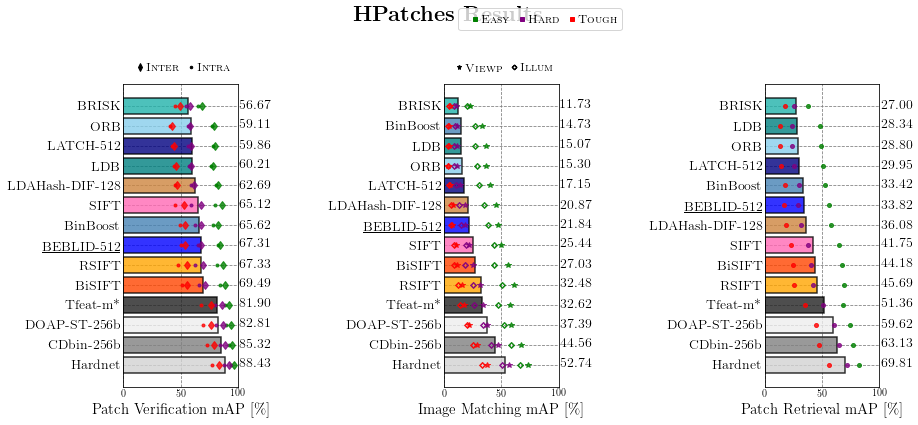

In [ ]:
# Plot results using matplotlib
logging.getLogger().setLevel(logging.INFO)
plot_hpatches_results(hpatches_results, output_dir, balanced_verification=False)
out_file = os.path.join(output_dir, 'hpatches_results.pdf')
logging.info("--> Comparison sucessfully generated in file \"{}\"".format(out_file))

In [ ]:
from google.colab import files
files.download('hpatches_results.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>